## Testing for Granger Causality Using Python

This article will demonstrate steps to check for Granger-Causality as outlined in the following research paper

##### Toda, H. Y and T. Yamamoto (1995). Statistical inferences in vector autoregressions with possibly integrated processes. Journal of Econometrics, 66, 225-250.


**Step 1**: Test each of the time-series to determine their order of integration. Ideally, this should involve using a test (such as the ADF test) for which the null hypothesis is non-stationarity; as well as a test (such as the KPSS test) for which the null is stationarity. It's good to have a cross-check

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
import pickle

In [4]:
data = pd.read_csv('daily-pm25-and-tweets.csv', index_col='time');
data.index = pd.to_datetime(data.index)
data = data.dropna()

In [5]:
data = data[data.index.month==12]

In [6]:
data

,PM2.5,freq
time,,
2016-12-01,239.925000,585.0
2016-12-02,183.933333,399.0
2016-12-03,199.562500,214.0
2016-12-04,232.316667,166.0
2016-12-05,209.612500,234.0
...,...,...
2019-12-26,198.495833,846.0
2019-12-27,220.841176,675.0
2019-12-29,359.250000,522.0


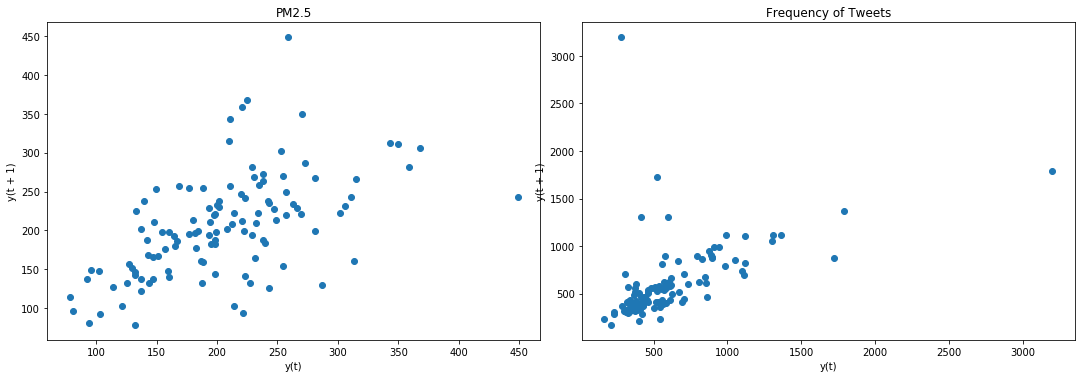

In [7]:
from pandas.plotting import lag_plot
   
f2, (ax4, ax5) = plt.subplots(1, 2, figsize=(15, 5))
f2.tight_layout()

lag_plot(data['PM2.5'], ax=ax4)
ax4.set_title('PM2.5');

lag_plot(data['freq'], ax=ax5)
ax5.set_title('Frequency of Tweets');

#lag_plot(series3, ax=ax6)
#ax6.set_title('Tweet and PM2.5');

plt.show()

**Result**: Data is not stationary. We will have to make it stationary using difference operation

In [8]:
#difference operation for sttionarity
rawData = data.copy(deep=True)


In [9]:
data['PM2.5'] = data['PM2.5'] - data['PM2.5'].shift(1)
data['freq'] = data['freq'] - data['freq'].shift(1)
data = data.dropna()

In [10]:
# split data into train and test. We will need this later for VAR analysis
msk = np.random.rand(len(data)) < 0.8
train = data[msk]
test = data[~msk]

In [11]:
## ADF Null hypothesis: there is a unit root, meaning series is non-stationary
from statsmodels.tsa.stattools import adfuller

X1 = np.array(data['freq'])
X1 = X1[~np.isnan(X1)]

result = adfuller(X1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
    
X2 = np.array(data['PM2.5'])
X2 = X2[~np.isnan(X2)]

result = adfuller(X2)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.110951
p-value: 0.000000
Critical Values:
	1%: -3.491
	5%: -2.888
	10%: -2.581
ADF Statistic: -9.867647
p-value: 0.000000
Critical Values:
	1%: -3.490
	5%: -2.887
	10%: -2.581


In [12]:
## KPSS Null hypothesis: there is a no unit root, meaning series is stationary
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(X1)
kpss_test(X2)

KPSS Statistic: 0.06485480791162834
p-value: 0.1
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
KPSS Statistic: 0.07356767365333704
p-value: 0.1
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


**Result**: 
ADF Null Hypothesis is rejected: Thus, data is stationary
KPSS Null Hypothesis could not be rejected. Thus, data is stationary

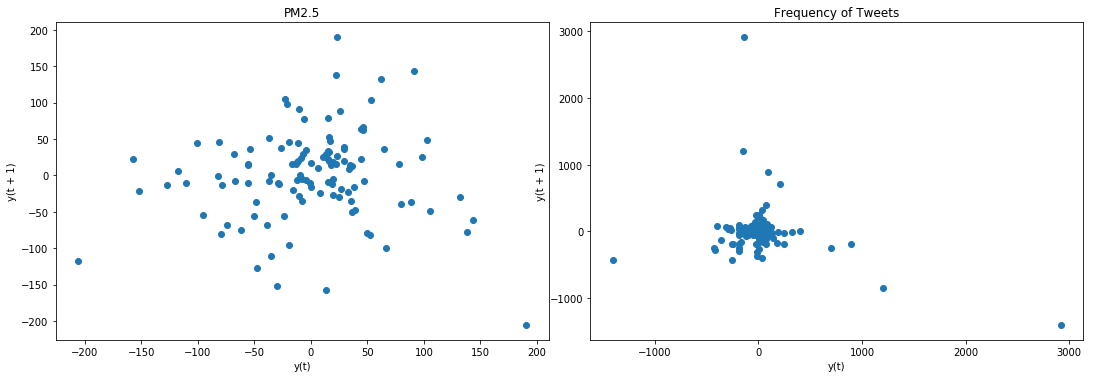

In [13]:
from pandas.plotting import lag_plot
   
f2, (ax4, ax5) = plt.subplots(1, 2, figsize=(15, 5))
f2.tight_layout()

lag_plot(data['PM2.5'], ax=ax4)
ax4.set_title('PM2.5');

lag_plot(data['freq'], ax=ax5)
ax5.set_title('Frequency of Tweets');

#lag_plot(series3, ax=ax6)
#ax6.set_title('Tweet and PM2.5');

plt.show()

**Result:** lag plot is in confirmatory with ADF test and KPSS test

**Step 2**: Let the maximum order of integration for the group of time-series be m. So, if there are two time-series and one is found to be I(1) and the other is I(2), then m = 2. If one is I(0) and the other is I(1), then m = 1, etc.

**Result:** We saw above that for our case m = 1

**Step 3:** Set up a VAR model in the levels of the data, regardless of the orders of integration of the various time-series. Most importantly, you must not difference the data, no matter what you found at Step 1.//

**Step 4:** Determine the appropriate maximum lag length for the variables in the VAR, say p, using the usual methods. Specifically, base the choice of p on the usual information criteria, such as AIC, SIC.

In [14]:
# obtain the lag P for VAR
rawData = rawData.dropna()
model = VAR(rawData) #recall that rawData is w/o difference operation
for i in [1,2,3,4,5,6,7,8,9,10,11,12]:
    result = model.fit(i)
    try:
        print('Lag Order =', i)
        print('AIC : ', result.aic)
        print('BIC : ', result.bic)
        print('FPE : ', result.fpe)
        print('HQIC: ', result.hqic, '\n')
    except:
        continue

Lag Order = 1
AIC :  19.629441227553993
BIC :  19.771868306404325
FPE :  334940780.8196355
HQIC:  19.687258485718587 

Lag Order = 2
AIC :  19.567018942303154
BIC :  19.80570869259561
FPE :  314699462.10562646
HQIC:  19.66390192110964 

Lag Order = 3
AIC :  19.638156898332547
BIC :  19.974181269188012
FPE :  337969524.61268705
HQIC:  19.77453035769041 

Lag Order = 4
AIC :  19.702476423888594
BIC :  20.13692758085162
FPE :  360554125.7788162
HQIC:  19.87877218055319 

Lag Order = 5
AIC :  19.77742043164484
BIC :  20.31141128136352
FPE :  388844844.9504808
HQIC:  19.994077497572654 

Lag Order = 6
AIC :  19.808248913495767
BIC :  20.44291364533469
FPE :  401375766.0338594
HQIC:  20.065713636213573 

Lag Order = 7
AIC :  19.887034790854397
BIC :  20.62352943607051
FPE :  434824881.5297186
HQIC:  20.185760995753196 

Lag Order = 8
AIC :  19.939692263223616
BIC :  20.779195272359313
FPE :  459121625.40472394
HQIC:  20.280141397671176 

Lag Order = 9
AIC :  19.945763075909056
BIC :  20.8894

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


**Result**: The lag-order p = 8 on the basis of Akaike Information Criterion (AIC)

**Step 5**: Make sure that the VAR is well-specified. For example, ensure that there is no serial correlation in the residuals. If need be, increase p until any autocorrelation issues are resolved.

In [15]:
model = VAR(train)
model_fitted = model.fit(2)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [16]:
#Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic
#The value of this statistic can vary between 0 and 4. 
#The closer it is to the value 2, then there is no significant serial correlation. 
#The closer to 0, there is a positive serial correlation, 
#and the closer it is to 4 implies negative serial correlation.


from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(data.columns, out):
    print(col, ':', round(val, 2))

PM2.5 : 2.11
freq : 1.94


**Result:** There is no significant correlation between in the residuals

**Step 6:** If two or more of the time-series have the same order of integration, at Step 1, then test to see if they are cointegrated, preferably using Johansen's methodology (based on your VAR) for a reliable result.

In [17]:
# I could not perform Johansen's test. Instead I check for co-integration using t-statistics

import statsmodels.tsa.stattools as ts 
result=ts.coint(data['PM2.5'], data['freq'])
print(result)

(-8.733109743193186, 4.1832001083487774e-13, array([-3.99420904, -3.38977722, -3.08153567]))


**Result**: The p-valus < 0.05. Thus rejecting the null hypothesis. Thus they are cointegrated.

**Step 7**: No matter what you conclude about cointegration at Step 6, this is not going to affect what follows. It just provides a possible cross-check on the validity of your results at the very end of the analysis.

**Step 8**: Now take the preferred VAR model and add in m additional lags of each of the variables into each of the equations.

Interesting, now here I will re-fit the VAR model using train data with a lag of 8 + 1. Recall that m = 1 in our case

In [18]:
model = VAR(train)
model_fitted = model.fit(2)
#get the lag order
lag_order = model_fitted.k_ar
print(lag_order)

2


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


**Step 9 and Step 10**:  Test for Granger non-causality. It's essential that you don't include the coefficients for the 'extra' m lags when you perform the tests. They are there just to fix up the asymptotics.

In [19]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=lag_order #becuase we got this value before. We are not suppose to add 1 to it
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

o = grangers_causation_matrix(train, variables = train.columns)  

In [20]:
o

,PM2.5_x,freq_x
PM2.5_y,1.0000,0.8018
freq_y,0.5644,1.0000


In [273]:
di['month'].append(11)
di['xCy'].append(o.iloc[0,1])
di['yCx'].append(o.iloc[1,0])

In [21]:
#xCy = Tweets causes PM2.5
#yXx = PM2.5 causes Tweets

In [11]:

with open('gc-p-value.pickle', 'wb') as handle:
    pickle.dump(b, handle, protocol=pickle.HIGHEST_PROTOCOL)

#with open('filename.pickle', 'rb') as handle:
#    b = pickle.load(handle)

**Result**: If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row).

**Step 11**: Finally, look back at what you concluded in Step 6 about cointegration. //
    
    "If two or more time-series are cointegrated, then there must be Granger causality between them - either one-way or in both directions. However, the converse is not true."
    
    "So, if your data are cointegrated but you don't find any evidence of causality, you have a conflict in your results. (This might occur if your sample size is too small to satisfy the asymptotics that the cointegration and causality tests rely on.) If you have cointegration and find one-way causality, everything is fine. (You may still be wrong about there being no causality in the other direction.) If your data are not cointegrated, then you have no cross-check on your causality results."

In [3]:
with open('gc-p-value.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [4]:
b

{'month': ['Jan',
  'Feb',
  'Mar',
  'Apr',
  'May',
  'Jun',
  'Jul',
  'Aug',
  'Sep',
  'Oct',
  'Nov',
  'Dec'],
 'xCy': [0.2469,
  0.2743,
  0.5351,
  0.4254,
  0.4388,
  0.087,
  0.4449,
  0.3465,
  0.4045,
  0.1082,
  0.0023,
  0.4861],
 'yCx': [0.5485,
  0.1676,
  0.819,
  0.8648,
  0.7661,
  0.0582,
  0.4366,
  0.4522,
  0.2495,
  0.0361,
  0.0,
  0.0023]}

In [5]:
d = pd.DataFrame.from_dict(b)
d.index = d['month']
d = d.drop(['month'], axis=1)

In [6]:
import latexify as lt
import matplotlib.patches as mpatches

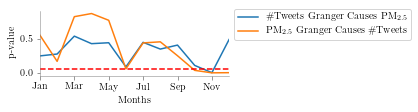

In [21]:
lt.latexify(fig_height=1.2)
ax = d.plot()
ax.set_ylabel('p-value', fontsize=10)
ax.set_xlabel('Months', fontsize=10)
ax.legend(['\#Tweets Granger Causes PM$_{2.5}$','PM$_{2.5}$ Granger Causes \#Tweets'],fontsize=10, bbox_to_anchor=[1,1.1])
ax.axhline(y=0.05,linestyle='--',color='r')
#red_patch = mpatches.Patch(color='red', label='p-value = 0.05')
#plt.legend(handles=[red_patch])
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
lt.format_axes(ax)
plt.savefig('granger-causality.pdf', bbox_inches='tight')